**Importing Libraries**

---



In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import os
import math as mat
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import nltk
from sklearn.linear_model import LogisticRegression
# install geopandas library
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import mean_squared_error
# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
#Notebook displace setting
from IPython.core.display import HTML
# css = open('style/style-table.css').read() + open('style/style-notebook.css').read()
css = open('/content/drive/Shareddrives/FIT5196_S1_2023/week6/style/style-table.css').read() + open('/content/drive/Shareddrives/FIT5196_S1_2023/week6/style/style-notebook.css').read()

HTML('<style>{}</style>'.format(css))

In [4]:
# downloads vader_lexicon module from nltk for sentiment analysis
nltk.download('vader_lexicon')  

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
# import modules from geopandas to plot map
import geopandas as gpd
from shapely.geometry import Point

In [6]:
# define regression model
model = LinearRegression()

In [7]:
# function to calculate arc distance between two locations
def calculate_min_distance(lat1,lat2,lon1,lon2):
  '''
  parameters:
    lat1: latitude value of location 1
    lat2: latitude value of location 2
    lon1: longitude value of location 1
    lon2: longitude value of location 2
  returns:
    float value which is the arc distance between the two coordinates
  '''
  # converts the coordinates to radians from degree
  lat1 = mat.radians(lat1)
  lat2 = mat.radians(lat2)
  long1 = mat.radians(lon1)
  long2 = mat.radians(lon2)
  lat = lat1 - lat2
  lon = long1 - long2
  # haversine formula to calculate the distance
  a = mat.sin(lat/2)**2 + mat.cos(lat2) * mat.cos(lat1) * mat.sin(lon/2)**2
  c = 2 * mat.asin(mat.sqrt(a)) 
  # multiply the arc distance with the radius of earth
  dist = 6378 * c
  # return the calculated distance
  return dist

In [8]:
# reads warehouse csv and stores in df
warehouse_df = pd.read_csv('/content/drive/Shareddrives/FIT5196_S1_2023/Assessment2/warehouses.csv')
warehouse_df

,names,lat,lon
0,Nickolson,-37.818595,144.969551
1,Thompson,-37.812673,144.947069
2,Bakers,-37.809996,144.995232


## **1: Missing Data**


---

This section of the assessnent identifies the missing data in the given file and fixes the data by imputing the values for all the missing columns.

In [9]:
# reads the file into a dataframe
missing_data_df = pd.read_csv('/content/drive/Shareddrives/FIT5196_S1_2023/Assessment2/student_data/31940757_missing_data.csv')
missing_data_df.head(5)

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD178426,ID6167266594,2022-10-12,NaN,"[('Lucent 330S', 1), ('Thunder line', 2)]",5590,40.345,-37.809520,144.963966,50,Spring,False,1.12326,"ugly phone, but fast got a new phone! so far t...",True
1,ORD013118,ID0452380704,2022-12-11,Thompson,"[('Toshika 750', 2), ('Universe Note', 2), ('A...",35900,NaN,-37.825349,144.953350,25,Summer,False,1.51530,very happy! nice phone! it was in excellent co...,True
2,ORD024502,ID0580530626,2022-07-29,Bakers,"[('pearTV', 1), ('iStream', 2), ('Lucent 330S'...",12160,NaN,-37.801219,145.008581,0,Winter,True,1.52743,"great phone, awsome pics. great phone, as some...",True
3,ORD322842,ID0634777739,2022-10-23,NaN,"[('pearTV', 2), ('iAssist Line', 1)]",14845,87.634,-37.814757,144.937776,0,Spring,True,0.84952,cracked it has a hairlinecrack along the back ...,False
4,ORD132962,ID6167231002,2022-02-07,Thompson,"[('Alcon 10', 2), ('Toshika 750', 2), ('Olivia...",28990,35.607,-37.815206,144.952550,50,Summer,False,0.55841,better options for what you spend on a redmi 6...,True


In [10]:
# returns the attributes from the each column in the df
missing_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              400 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    500 non-null    int64  
 6   delivery_charges               450 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   delivery_discount              500 non-null    int64  
 10  season                         500 non-null    object 
 11  is_expedited_delivery          500 non-null    bool   
 12  distance_to_nearest_warehouse  450 non-null    flo

It is clear from the above code that we have three columns where we have null values:


*   **nearest_warehouse:** 100 records
*   **delivery_charges:** 50 records
*   **distance_to_nearest_warehouse:** 50 records








In [11]:
# return list of indices where the filtered columns have null values
null_warehouses = missing_data_df[['nearest_warehouse','distance_to_nearest_warehouse']].isnull().any(axis=1)
# creates df containing the rows for above indices
loc_miss_df = missing_data_df[null_warehouses]
loc_miss_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD178426,ID6167266594,2022-10-12,NaN,"[('Lucent 330S', 1), ('Thunder line', 2)]",5590,40.345,-37.809520,144.963966,50,Spring,False,1.12326,"ugly phone, but fast got a new phone! so far t...",True
3,ORD322842,ID0634777739,2022-10-23,NaN,"[('pearTV', 2), ('iAssist Line', 1)]",14845,87.634,-37.814757,144.937776,0,Spring,True,0.84952,cracked it has a hairlinecrack along the back ...,False
8,ORD053385,ID0055723357,2022-11-08,NaN,"[('Olivia x460', 2), ('Lucent 330S', 2), ('Tos...",13550,64.276,-37.808678,144.957859,0,Spring,False,1.04794,lack of seriousness in delivery times are not ...,False
10,ORD040326,ID0036822340,2022-02-24,NaN,"[('Toshika 750', 2), ('pearTV', 2), ('Thunder ...",25620,95.837,-37.820920,144.957898,0,Summer,True,1.05689,step a side pear and universe. this phone is f...,True
16,ORD345078,ID1985361802,2022-07-23,NaN,"[('iAssist Line', 2), ('Toshika 750', 1)]",8770,33.930,-37.808471,144.961669,50,Winter,False,NaN,"five stars great phone, no scratches or anythi...",True


In [12]:
# defines the latitudes and longitudes for the warehouses
nicolson_lat = warehouse_df.loc[0,'lat']
nicolson_long = warehouse_df.loc[0,'lon']
thompson_lat = warehouse_df.loc[1,'lat']
thompson_long = warehouse_df.loc[1,'lon']
bakers_lat = warehouse_df.loc[2,'lat']
bakers_long = warehouse_df.loc[2,'lon']
# iterates over the missing data df
for i in list(loc_miss_df.index.values):
  # defines the customer's locations
  long1 = loc_miss_df.loc[i, 'customer_long']
  lat1 = loc_miss_df.loc[i, 'customer_lat']
  # distance from nicolson
  dist_n = round(calculate_min_distance(lat1, nicolson_lat, 
                                        long1, nicolson_long), 5)
  # distance from thompson
  dist_t = round(calculate_min_distance(lat1, thompson_lat, 
                                        long1, thompson_long), 5)
  # distance from bakers
  dist_b = round(calculate_min_distance(lat1, bakers_lat, 
                                        long1, bakers_long), 5)
  # checks if the distance and nearest warehouse is missing 
  if (np.isnan(loc_miss_df.loc[i, 'distance_to_nearest_warehouse']) and 
      np.isnan(loc_miss_df.loc[i, 'nearest_warehouse'])):
    # checks for the least distance between the customers and the warehouses
    dist = min(dist_n, dist_t, dist_b)
    # if dist is equal to distance from Nickolson
    if dist == dist_n:
      # impute the missing values for Nickolson
      missing_data_df.at[i, "nearest_warehouse"] = "Nickolson"
      missing_data_df.at[i, "distance_to_nearest_warehouse"] = dist
    # if dist is equal to distance from Thompson
    elif dist == dist_t:
      # impute the missing values for Thompson
      missing_data_df.at[i, "nearest_warehouse"] = "Thompson"
      missing_data_df.at[i, "distance_to_nearest_warehouse"] = dist
    # if dist is equal to distance from Bakers
    else:
      # impute the missing values for Bakers
      missing_data_df.at[i, "nearest_warehouse"] = "Bakers"
      missing_data_df.at[i, "distance_to_nearest_warehouse"] = dist
  # checks if only distance is missing
  elif np.isnan(loc_miss_df.loc[i, 'distance_to_nearest_warehouse']):
    # checks for warehouse location in df
    if loc_miss_df.loc[i, 'nearest_warehouse'] == 'Nickolson':
      # impute the missing values
      missing_data_df.at[i, "distance_to_nearest_warehouse"] = dist_n
    elif loc_miss_df.loc[i, 'nearest_warehouse'] == 'Thompson':
      missing_data_df.at[i, "distance_to_nearest_warehouse"] = dist_t
    else:
      missing_data_df.at[i, "distance_to_nearest_warehouse"] = dist_b
  # checks if the nearest_warehouse is missing
  else:
    # checks if distance from Nickolson is equal to actual distance
    if dist_n == round(loc_miss_df.loc[i, 'distance_to_nearest_warehouse'],5):
      missing_data_df.at[i, "nearest_warehouse"] = "Nickolson"
    # checks if distance from thompson is equal to actual distance
    elif dist_t == round(loc_miss_df.loc[i, 'distance_to_nearest_warehouse'],5):
      missing_data_df.at[i, "nearest_warehouse"] = "Thompson"
    else:
      missing_data_df.at[i, "nearest_warehouse"] = "Bakers"
null_warehouses = missing_data_df[['nearest_warehouse','distance_to_nearest_warehouse']].isnull().any(axis=1)

In [13]:
null_warehouses.describe(include = 'O')

count       500
unique        1
top       False
freq        500
dtype: object

Since the delivery charges are linealry dependent in the season, distance, customer satisfaction and expedited delivery we need to make a linear model where delivery charge is treated as a dependent variable. Also the delivery charge in the data contains the discouted amount therefore we need to calculate the actual delivery charge before fitting the data to the model.

In [14]:
discounted_price = 0
# iterates through the df
for i in list(missing_data_df.index.values):
  # calcuates delivery charges without the discount
  discounted_price = (missing_data_df.loc[i,"delivery_charges"])/(1 - (missing_data_df.loc[i,"delivery_discount"]/100))
  missing_data_df.at[i,"delivery_charges"] = discounted_price
missing_data_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD178426,ID6167266594,2022-10-12,Nickolson,"[('Lucent 330S', 1), ('Thunder line', 2)]",5590,80.690,-37.809520,144.963966,50,Spring,False,1.12326,"ugly phone, but fast got a new phone! so far t...",True
1,ORD013118,ID0452380704,2022-12-11,Thompson,"[('Toshika 750', 2), ('Universe Note', 2), ('A...",35900,NaN,-37.825349,144.953350,25,Summer,False,1.51530,very happy! nice phone! it was in excellent co...,True
2,ORD024502,ID0580530626,2022-07-29,Bakers,"[('pearTV', 1), ('iStream', 2), ('Lucent 330S'...",12160,NaN,-37.801219,145.008581,0,Winter,True,1.52743,"great phone, awsome pics. great phone, as some...",True
3,ORD322842,ID0634777739,2022-10-23,Thompson,"[('pearTV', 2), ('iAssist Line', 1)]",14845,87.634,-37.814757,144.937776,0,Spring,True,0.84952,cracked it has a hairlinecrack along the back ...,False
4,ORD132962,ID6167231002,2022-02-07,Thompson,"[('Alcon 10', 2), ('Toshika 750', 2), ('Olivia...",28990,71.214,-37.815206,144.952550,50,Summer,False,0.55841,better options for what you spend on a redmi 6...,True


In [15]:
# returns a df of indices where delivery charges are missing
missing_delivery = missing_data_df[['delivery_charges']].isnull().any(axis=1)
# subsets the main df with only the data where delivery charges are missing
price_miss_df = missing_data_df[missing_delivery]
price_miss_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
1,ORD013118,ID0452380704,2022-12-11,Thompson,"[('Toshika 750', 2), ('Universe Note', 2), ('A...",35900,NaN,-37.825349,144.953350,25,Summer,False,1.51530,very happy! nice phone! it was in excellent co...,True
2,ORD024502,ID0580530626,2022-07-29,Bakers,"[('pearTV', 1), ('iStream', 2), ('Lucent 330S'...",12160,NaN,-37.801219,145.008581,0,Winter,True,1.52743,"great phone, awsome pics. great phone, as some...",True
6,ORD376008,ID3085953493,2022-11-26,Nickolson,"[('Olivia x460', 1), ('Alcon 10', 1), ('pearTV...",23655,NaN,-37.817750,144.974697,50,Spring,True,0.46222,network bandwidth all good beside the network ...,True
7,ORD244777,ID1713460586,2022-08-01,Bakers,"[('Candle Inferno', 2), ('Toshika 750', 2), ('...",14175,NaN,-37.808845,144.983892,25,Winter,True,1.00553,the digico inferno hd8 is awesome! easy to nav...,True
30,ORD254575,ID0283530679,2022-07-29,Nickolson,"[('pearTV', 1), ('Lucent 330S', 2), ('Universe...",12220,NaN,-37.817354,144.973499,50,Winter,False,0.37362,pink and green display lines appeared after 3 ...,False


In [16]:
# drops all the rows where delivery charge is null
lm_data_df = missing_data_df.dropna(subset=['delivery_charges'])
lm_data_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD178426,ID6167266594,2022-10-12,Nickolson,"[('Lucent 330S', 1), ('Thunder line', 2)]",5590,80.690,-37.809520,144.963966,50,Spring,False,1.12326,"ugly phone, but fast got a new phone! so far t...",True
3,ORD322842,ID0634777739,2022-10-23,Thompson,"[('pearTV', 2), ('iAssist Line', 1)]",14845,87.634,-37.814757,144.937776,0,Spring,True,0.84952,cracked it has a hairlinecrack along the back ...,False
4,ORD132962,ID6167231002,2022-02-07,Thompson,"[('Alcon 10', 2), ('Toshika 750', 2), ('Olivia...",28990,71.214,-37.815206,144.952550,50,Summer,False,0.55841,better options for what you spend on a redmi 6...,True
5,ORD004377,ID6202471403,2022-09-03,Nickolson,"[('Universe Note', 1), ('Lucent 330S', 1)]",4680,74.084,-37.821332,144.976986,25,Spring,False,0.72128,gophone very easy to use for basic text and talk,True
8,ORD053385,ID0055723357,2022-11-08,Thompson,"[('Olivia x460', 2), ('Lucent 330S', 2), ('Tos...",13550,64.276,-37.808678,144.957859,0,Spring,False,1.04794,lack of seriousness in delivery times are not ...,False


Since all the independent variables are categorical we use one-hot encoding method to encode the data to numerical equivalent. Choosing this technique will reduce the bias that might be caused by splitting the data into seasons and making four different models as the size of the training datset will significantly reduced.

In [17]:
# encodes the seasons to a numeric value
season_encoded = pd.get_dummies(lm_data_df['season'], prefix='season')
# adds the encoded season to the actual df
lm_data_encoded = pd.concat([lm_data_df, season_encoded], axis=1)
# converts boolean to int binary type
lm_data_encoded['is_expedited_delivery'] = lm_data_encoded['is_expedited_delivery'].astype(int)
lm_data_encoded['is_happy_customer'] = lm_data_encoded['is_happy_customer'].astype(int)
lm_data_encoded.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,season_Autumn,season_Spring,season_Summer,season_Winter
0,ORD178426,ID6167266594,2022-10-12,Nickolson,"[('Lucent 330S', 1), ('Thunder line', 2)]",5590,80.690,-37.809520,144.963966,50,Spring,0,1.12326,"ugly phone, but fast got a new phone! so far t...",1,0,1,0,0
3,ORD322842,ID0634777739,2022-10-23,Thompson,"[('pearTV', 2), ('iAssist Line', 1)]",14845,87.634,-37.814757,144.937776,0,Spring,1,0.84952,cracked it has a hairlinecrack along the back ...,0,0,1,0,0
4,ORD132962,ID6167231002,2022-02-07,Thompson,"[('Alcon 10', 2), ('Toshika 750', 2), ('Olivia...",28990,71.214,-37.815206,144.952550,50,Summer,0,0.55841,better options for what you spend on a redmi 6...,1,0,0,1,0
5,ORD004377,ID6202471403,2022-09-03,Nickolson,"[('Universe Note', 1), ('Lucent 330S', 1)]",4680,74.084,-37.821332,144.976986,25,Spring,0,0.72128,gophone very easy to use for basic text and talk,1,0,1,0,0
8,ORD053385,ID0055723357,2022-11-08,Thompson,"[('Olivia x460', 2), ('Lucent 330S', 2), ('Tos...",13550,64.276,-37.808678,144.957859,0,Spring,0,1.04794,lack of seriousness in delivery times are not ...,0,0,1,0,0


In [18]:
# dataset containing independent variables
X = lm_data_encoded[['season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter',
          'is_expedited_delivery', 'distance_to_nearest_warehouse', 'is_happy_customer']]
# dataset containing dependent variables
y = lm_data_encoded['delivery_charges']

# splits the dataset into test and train with a proportion of 20% and 80% respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# train the model with the training dataset
model.fit(X_train, y_train)

# returns model accuracy for the test dataset
r_squared = model.score(X_test, y_test)

print('R-squared (coefficient of determination):', r_squared)

R-squared (coefficient of determination): 0.9660416102195948


Since, the r-squared value is 96% > 95% we are going to use this model to predict the values of missing delivery charges.

In [19]:
# encodes the seasons to a numeric value
season_encoded = pd.get_dummies(price_miss_df['season'], prefix='season')
# adds the encoded season to the actual df
price_miss_df_encoded = pd.concat([price_miss_df, season_encoded], axis=1)
# converts boolean to int binary type
price_miss_df_encoded['is_expedited_delivery'] = price_miss_df_encoded['is_expedited_delivery'].astype(int)
price_miss_df_encoded['is_happy_customer'] = price_miss_df_encoded['is_happy_customer'].astype(int)
price_miss_df_encoded.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,season_Autumn,season_Spring,season_Summer,season_Winter
1,ORD013118,ID0452380704,2022-12-11,Thompson,"[('Toshika 750', 2), ('Universe Note', 2), ('A...",35900,NaN,-37.825349,144.953350,25,Summer,0,1.51530,very happy! nice phone! it was in excellent co...,1,0,0,1,0
2,ORD024502,ID0580530626,2022-07-29,Bakers,"[('pearTV', 1), ('iStream', 2), ('Lucent 330S'...",12160,NaN,-37.801219,145.008581,0,Winter,1,1.52743,"great phone, awsome pics. great phone, as some...",1,0,0,0,1
6,ORD376008,ID3085953493,2022-11-26,Nickolson,"[('Olivia x460', 1), ('Alcon 10', 1), ('pearTV...",23655,NaN,-37.817750,144.974697,50,Spring,1,0.46222,network bandwidth all good beside the network ...,1,0,1,0,0
7,ORD244777,ID1713460586,2022-08-01,Bakers,"[('Candle Inferno', 2), ('Toshika 750', 2), ('...",14175,NaN,-37.808845,144.983892,25,Winter,1,1.00553,the digico inferno hd8 is awesome! easy to nav...,1,0,0,0,1
30,ORD254575,ID0283530679,2022-07-29,Nickolson,"[('pearTV', 1), ('Lucent 330S', 2), ('Universe...",12220,NaN,-37.817354,144.973499,50,Winter,0,0.37362,pink and green display lines appeared after 3 ...,0,0,0,0,1


In [20]:
# datasets from the missing df
X = price_miss_df_encoded[['season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter',
          'is_expedited_delivery', 'distance_to_nearest_warehouse', 'is_happy_customer']]
y = price_miss_df_encoded['delivery_charges']
# predicts the delivery charges and impute the missing values
price_miss_df_encoded['delivery_charges'][price_miss_df_encoded['delivery_charges'].isnull()] = model.predict(X)
price_miss_df_encoded.head()

<ipython-input-20-bc1ee749ab88>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_miss_df_encoded['delivery_charges'][price_miss_df_encoded['delivery_charges'].isnull()] = model.predict(X)


,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,season_Autumn,season_Spring,season_Summer,season_Winter
1,ORD013118,ID0452380704,2022-12-11,Thompson,"[('Toshika 750', 2), ('Universe Note', 2), ('A...",35900,79.9375,-37.825349,144.953350,25,Summer,0,1.51530,very happy! nice phone! it was in excellent co...,1,0,0,1,0
2,ORD024502,ID0580530626,2022-07-29,Bakers,"[('pearTV', 1), ('iStream', 2), ('Lucent 330S'...",12160,85.1250,-37.801219,145.008581,0,Winter,1,1.52743,"great phone, awsome pics. great phone, as some...",1,0,0,0,1
6,ORD376008,ID3085953493,2022-11-26,Nickolson,"[('Olivia x460', 1), ('Alcon 10', 1), ('pearTV...",23655,96.4375,-37.817750,144.974697,50,Spring,1,0.46222,network bandwidth all good beside the network ...,1,0,1,0,0
7,ORD244777,ID1713460586,2022-08-01,Bakers,"[('Candle Inferno', 2), ('Toshika 750', 2), ('...",14175,81.5000,-37.808845,144.983892,25,Winter,1,1.00553,the digico inferno hd8 is awesome! easy to nav...,1,0,0,0,1
30,ORD254575,ID0283530679,2022-07-29,Nickolson,"[('pearTV', 1), ('Lucent 330S', 2), ('Universe...",12220,43.5625,-37.817354,144.973499,50,Winter,0,0.37362,pink and green display lines appeared after 3 ...,0,0,0,0,1


In [21]:
# iterates over missing df
for i in list(price_miss_df_encoded.index.values):
  # caluclates the delivery price by adding the discounted amount
  missing_data_df.at[i,'delivery_charges'] = price_miss_df_encoded.loc[i,"delivery_charges"]
missing_data_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD178426,ID6167266594,2022-10-12,Nickolson,"[('Lucent 330S', 1), ('Thunder line', 2)]",5590,80.6900,-37.809520,144.963966,50,Spring,False,1.12326,"ugly phone, but fast got a new phone! so far t...",True
1,ORD013118,ID0452380704,2022-12-11,Thompson,"[('Toshika 750', 2), ('Universe Note', 2), ('A...",35900,79.9375,-37.825349,144.953350,25,Summer,False,1.51530,very happy! nice phone! it was in excellent co...,True
2,ORD024502,ID0580530626,2022-07-29,Bakers,"[('pearTV', 1), ('iStream', 2), ('Lucent 330S'...",12160,85.1250,-37.801219,145.008581,0,Winter,True,1.52743,"great phone, awsome pics. great phone, as some...",True
3,ORD322842,ID0634777739,2022-10-23,Thompson,"[('pearTV', 2), ('iAssist Line', 1)]",14845,87.6340,-37.814757,144.937776,0,Spring,True,0.84952,cracked it has a hairlinecrack along the back ...,False
4,ORD132962,ID6167231002,2022-02-07,Thompson,"[('Alcon 10', 2), ('Toshika 750', 2), ('Olivia...",28990,71.2140,-37.815206,144.952550,50,Summer,False,0.55841,better options for what you spend on a redmi 6...,True


In [22]:
# iterates over missing df
for i in list(missing_data_df.index.values):
  # caluclates the delivery price by adding the discounted amount
  discounted_price = round((missing_data_df.loc[i,"delivery_charges"])*(1 - (missing_data_df.loc[i,"delivery_discount"]/100)),5)
  missing_data_df.at[i,'delivery_charges'] = discounted_price
missing_data_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD178426,ID6167266594,2022-10-12,Nickolson,"[('Lucent 330S', 1), ('Thunder line', 2)]",5590,40.34500,-37.809520,144.963966,50,Spring,False,1.12326,"ugly phone, but fast got a new phone! so far t...",True
1,ORD013118,ID0452380704,2022-12-11,Thompson,"[('Toshika 750', 2), ('Universe Note', 2), ('A...",35900,59.95312,-37.825349,144.953350,25,Summer,False,1.51530,very happy! nice phone! it was in excellent co...,True
2,ORD024502,ID0580530626,2022-07-29,Bakers,"[('pearTV', 1), ('iStream', 2), ('Lucent 330S'...",12160,85.12500,-37.801219,145.008581,0,Winter,True,1.52743,"great phone, awsome pics. great phone, as some...",True
3,ORD322842,ID0634777739,2022-10-23,Thompson,"[('pearTV', 2), ('iAssist Line', 1)]",14845,87.63400,-37.814757,144.937776,0,Spring,True,0.84952,cracked it has a hairlinecrack along the back ...,False
4,ORD132962,ID6167231002,2022-02-07,Thompson,"[('Alcon 10', 2), ('Toshika 750', 2), ('Olivia...",28990,35.60700,-37.815206,144.952550,50,Summer,False,0.55841,better options for what you spend on a redmi 6...,True


In [23]:
missing_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              500 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    500 non-null    int64  
 6   delivery_charges               500 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   delivery_discount              500 non-null    int64  
 10  season                         500 non-null    object 
 11  is_expedited_delivery          500 non-null    bool   
 12  distance_to_nearest_warehouse  500 non-null    flo

In [24]:
final_missing_data_df = missing_data_df.copy()

In [25]:
# creates a csv file from the imputed data df
final_missing_data_df.to_csv('/content/drive/MyDrive/Assessment2/31940757_missing_data_solution.csv',
index = False)

## **2: Cleaning Data**

---
This section deals with cleaning the dirty data csv file. Firstly the data is loaded from the csv file to a dataframe and analysed.
This step involves checking the shape of the df which gives us the number of rows and columns in the df.

Next we used df.info() which returns the description of column, its datatype and if or nor it contains null values.

After this we perform Exploratory Data Analysis on the df to check for the statistics of the numerical data which includes mean, max, min, etc. values from the columns. Categorical data its count, freq,top and unique values from the columns.

In [26]:
# change the working directory to the local folder
os.chdir("/content/drive/MyDrive")
#os.mkdir("./Assessment2")

In [27]:
os.chdir("./Assessment2")

In [28]:
# reads the dirty data file in the shared drive and stores in the data frame
dirty_data_raw = pd.read_csv("/content/drive/Shareddrives/FIT5196_S1_2023/Assessment2/student_data/31940757_dirty_data.csv")
# prints the top rows from the df
dirty_data_raw.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD430562,ID0641028631,2022-07-11,Thompson,"[('Universe Note', 2), ('Lucent 330S', 1), ('A...",26030,56.593,-37.810492,144.943228,25,Winter,True,0.41601,"great deal really responsive, large colorful s...",True
1,ORD247368,ID6167413282,2022-12-04,Thompson,"[('Lucent 330S', 2), ('Olivia x460', 2), ('iSt...",5060,94.560,-37.816226,144.956720,0,Summer,True,0.93635,it works just like a olivia universe s4 that w...,True
2,ORD444928,ID1281079287,2022-06-11,Thompson,"[('Toshika 750', 2), ('pearTV', 1)]",14950,41.693,-37.799622,144.955018,50,Winter,True,1.61224,love the phone. i had one at full price. but l...,True
3,ORD494678,ID0664380400,2022-06-01,thompson,"[('Thunder line', 2), ('Universe Note', 1), ('...",10270,42.785,-37.819663,144.972732,25,Winter,True,0.30392,digico sucks!!! the touchscreen got messed up ...,False
4,ORD313132,ID0598347145,2022-12-04,Nickolson,"[('Olivia x460', 2), ('iStream', 2), ('Candle ...",3180,36.466,-37.814024,144.963355,50,Summer,False,0.74547,better than expected still learning how to use...,True


In [29]:
# prints shape of the dataframe
print (dirty_data_raw.shape)

(500, 15)


* Categorical Variables: <font color="green">nearest_warehouse</font>, <font color="green">shopping_cart</font>, <font color="green">season</font>, <font color="green">is_expedited_delivery</font>, <font color="green">latest_customer_review</font>, <font color="green">is_happy_customer</font>
    * Ordinal variables: <font color="green">order_id</font>, <font color="green">customer_id</font>, <font color="green">date</font>
* Numerical Variables: <font color="red">order_price</font>, <font color="red">delivery_charges</font>, <font color="red">customer_lat</font>, <font color="red">customer_long</font>, <font color="red">delivery_discount</font>, <font color="red">distance_to_nearest_warehouse</font>

In [30]:
# gives description of the columns in df
dirty_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              500 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    500 non-null    int64  
 6   delivery_charges               500 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   delivery_discount              500 non-null    int64  
 10  season                         500 non-null    object 
 11  is_expedited_delivery          500 non-null    bool   
 12  distance_to_nearest_warehouse  500 non-null    flo

In [31]:
# returns statical inference for the numerical data
dirty_data_raw.describe()

,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,distance_to_nearest_warehouse
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,13716.670000,57.707388,-35.984306,143.138541,24.500000,1.043119
std,8119.280374,18.925138,18.204181,18.204195,20.138548,0.460652
min,730.000000,23.411000,-37.826078,-37.817489,0.000000,0.065600
25%,7715.000000,41.077250,-37.818107,144.951818,0.000000,0.721738
50%,12225.000000,57.460500,-37.812178,144.963344,25.000000,1.025200
75%,18461.250000,71.366750,-37.805890,144.979236,50.000000,1.321572
max,42610.000000,109.217000,144.983375,145.016421,50.000000,2.250810


Latitude Ranges between [-90, 90] while Longtitude ranges between [-180, 180]. Also Melbourne is located at -37.840935, 144.946457. Since we are given that the store is based in Melbourne, the latitude and longitude values should be within the proximity of Melbourne therefore the Min and Max of Latitude and Longitude needs to be checked.

In [32]:
# returns the statical inference for the categorical data
dirty_data_raw.describe(include=['O'])

,order_id,customer_id,date,nearest_warehouse,shopping_cart,season,latest_customer_review
count,500,500,500,500,500,500,499
unique,500,494,282,6,467,7,499
top,ORD430562,ID0711333376,2022-06-23,Thompson,"[('Olivia x460', 2), ('Alcon 10', 1)]",Winter,"great deal really responsive, large colorful s..."
freq,1,2,5,212,4,132,1




1.   We are given that there are three warehouses but there are six unique values.
2.   We only experience four season but there are seven unique values.




In [33]:
# adds new column to the dataframe with a default value False
dirty_data_raw["dirty_flag"] = False
dirty_data_raw.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,dirty_flag
0,ORD430562,ID0641028631,2022-07-11,Thompson,"[('Universe Note', 2), ('Lucent 330S', 1), ('A...",26030,56.593,-37.810492,144.943228,25,Winter,True,0.41601,"great deal really responsive, large colorful s...",True,False
1,ORD247368,ID6167413282,2022-12-04,Thompson,"[('Lucent 330S', 2), ('Olivia x460', 2), ('iSt...",5060,94.560,-37.816226,144.956720,0,Summer,True,0.93635,it works just like a olivia universe s4 that w...,True,False
2,ORD444928,ID1281079287,2022-06-11,Thompson,"[('Toshika 750', 2), ('pearTV', 1)]",14950,41.693,-37.799622,144.955018,50,Winter,True,1.61224,love the phone. i had one at full price. but l...,True,False
3,ORD494678,ID0664380400,2022-06-01,thompson,"[('Thunder line', 2), ('Universe Note', 1), ('...",10270,42.785,-37.819663,144.972732,25,Winter,True,0.30392,digico sucks!!! the touchscreen got messed up ...,False,False
4,ORD313132,ID0598347145,2022-12-04,Nickolson,"[('Olivia x460', 2), ('iStream', 2), ('Candle ...",3180,36.466,-37.814024,144.963355,50,Summer,False,0.74547,better than expected still learning how to use...,True,False


In [34]:
# returns the unique values in the column season with their count of occurance
dirty_data_raw.season.value_counts()

Winter    132
Summer    132
Autumn    122
Spring    109
autumn      2
summer      2
spring      1
Name: season, dtype: int64

In [35]:
# returns the filtered dataframe 
filtered_seasons = dirty_data_raw[(dirty_data_raw["season"] == 'autumn') |
                                  (dirty_data_raw["season"] == 'summer') |
                                  (dirty_data_raw["season"] == 'spring')]
filtered_seasons

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,dirty_flag
69,ORD075238,ID3163996209,2022-03-29,Thompson,"[('Thunder line', 2), ('Toshika 750', 1), ('Al...",17630,39.875,-37.802609,144.957187,25,autumn,False,1.43076,"money back sigo esperando mi reembolso, no se ...",False,False
77,ORD265602,ID6167247184,2022-10-28,Nickolson,"[('Lucent 330S', 2), ('pearTV', 2), ('iStream'...",23870,46.728,-37.819766,144.959023,25,autumn,False,0.93493,not unlocked phone was supposed to come unlock...,False,False
103,ORD382927,ID6167236696,2022-07-22,Nickolson,"[('Candle Inferno', 2), ('pearTV', 2), ('Lucen...",18160,58.366,-37.812819,144.960850,25,spring,True,0.99945,"bundle? i love the phone already, i have owned...",True,False
240,ORD322165,ID1463656474,2022-02-22,Bakers,"[('Universe Note', 1), ('Alcon 10', 2)]",21350,46.557,-37.815867,144.999642,50,summer,True,0.75998,s9 dual sim from electrocell / fulfilled by di...,True,False
283,ORD393732,ID4735688204,2022-01-21,Thompson,"[('Thunder line', 2), ('pearTV', 1), ('Toshika...",18440,78.492,-37.803644,144.949380,0,summer,True,1.02545,this refurbished phone was defective. the phon...,False,False


In [36]:
#  replaces cell containing the keys with the values in the dict
dirty_data_raw['season'] = dirty_data_raw.season.replace({"autumn":"Autumn","summer":"Summer","spring":"Spring"})

In [37]:
# retruns value count after modifying thr dirty data
dirty_data_raw.season.value_counts()

Summer    134
Winter    132
Autumn    124
Spring    110
Name: season, dtype: int64

In [38]:
# list of index values for modified records 
index_values = list(filtered_seasons.index.values)
for i in index_values:
  # sets the dirty flag column to true for the records that are modified.
  dirty_data_raw.at[i, "dirty_flag"] = True

In [39]:
# returns the modified records from the df
dirty_data_raw[dirty_data_raw["dirty_flag"] == True]

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,dirty_flag
69,ORD075238,ID3163996209,2022-03-29,Thompson,"[('Thunder line', 2), ('Toshika 750', 1), ('Al...",17630,39.875,-37.802609,144.957187,25,Autumn,False,1.43076,"money back sigo esperando mi reembolso, no se ...",False,True
77,ORD265602,ID6167247184,2022-10-28,Nickolson,"[('Lucent 330S', 2), ('pearTV', 2), ('iStream'...",23870,46.728,-37.819766,144.959023,25,Autumn,False,0.93493,not unlocked phone was supposed to come unlock...,False,True
103,ORD382927,ID6167236696,2022-07-22,Nickolson,"[('Candle Inferno', 2), ('pearTV', 2), ('Lucen...",18160,58.366,-37.812819,144.960850,25,Spring,True,0.99945,"bundle? i love the phone already, i have owned...",True,True
240,ORD322165,ID1463656474,2022-02-22,Bakers,"[('Universe Note', 1), ('Alcon 10', 2)]",21350,46.557,-37.815867,144.999642,50,Summer,True,0.75998,s9 dual sim from electrocell / fulfilled by di...,True,True
283,ORD393732,ID4735688204,2022-01-21,Thompson,"[('Thunder line', 2), ('pearTV', 1), ('Toshika...",18440,78.492,-37.803644,144.949380,0,Summer,True,1.02545,this refurbished phone was defective. the phon...,False,True


In [40]:
#returns the unique values in the column nearest_warehouse with their count of occurance
dirty_data_raw.nearest_warehouse.value_counts()

Thompson     212
Nickolson    171
Bakers       109
bakers         3
nickolson      3
thompson       2
Name: nearest_warehouse, dtype: int64

In [41]:
# filtered df containing the dirty values for nearest_warehouse
filtered_warehouses = dirty_data_raw[(dirty_data_raw["nearest_warehouse"] == 'bakers') |
                                  (dirty_data_raw["nearest_warehouse"] == 'nickolson') |
                                  (dirty_data_raw["nearest_warehouse"] == 'thompson')]
filtered_warehouses

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,dirty_flag
3,ORD494678,ID0664380400,2022-06-01,thompson,"[('Thunder line', 2), ('Universe Note', 1), ('...",10270,42.785,-37.819663,144.972732,25,Winter,True,0.30392,digico sucks!!! the touchscreen got messed up ...,False,False
72,ORD129609,ID1217532949,2022-06-21,bakers,"[('Universe Note', 1), ('Olivia x460', 1)]",4675,37.314,-37.818048,144.948613,25,Winter,False,0.61352,wrong model # the description says it's model ...,False,False
114,ORD081301,ID0506049794,2022-04-01,thompson,"[('Lucent 330S', 2), ('pearTV', 2), ('Candle I...",16735,65.951,-37.814841,144.938077,0,Autumn,False,0.82677,us bans huawei? looks like us government may b...,True,False
249,ORD469228,ID2385153634,2022-12-06,nickolson,"[('pearTV', 2), ('Olivia x460', 1), ('Thunder ...",16025,41.268,-37.800822,144.941757,50,Summer,True,1.39950,it was locked i bought it as unlocked. however...,False,False
389,ORD164910,ID3148722376,2022-07-20,bakers,"[('Lucent 330S', 1), ('iAssist Line', 1), ('Th...",14715,78.916,-37.821115,144.957769,0,Winter,True,1.07338,excellent phone good camera and elegant,True,False
393,ORD242943,ID0607756866,2022-10-04,nickolson,"[('iStream', 2), ('Alcon 10', 1), ('Universe N...",16150,100.092,-37.817419,144.961920,0,Spring,True,0.68370,"i use to read books, watch movies, and get onl...",True,False
437,ORD173647,ID0387152966,2022-01-20,bakers,"[('Olivia x460', 2), ('iAssist Line', 2), ('pe...",20750,50.785,-37.798812,144.948918,50,Summer,True,1.55158,all the spects are great but don't get carried...,True,False
478,ORD294705,ID1725216706,2022-06-20,nickolson,"[('iStream', 2), ('Universe Note', 2), ('iAssi...",15735,70.425,-37.804441,144.964856,0,Winter,False,1.62878,five stars works great,True,False


In [42]:
# replaces the dirty values in nearest_warehouse with the actual values
dirty_data_raw['nearest_warehouse'] = dirty_data_raw.nearest_warehouse.replace({"nickolson":"Nickolson","bakers":"Bakers","thompson":"Thompson"})

In [43]:
# returns the value count after modification
dirty_data_raw.nearest_warehouse.value_counts()

Thompson     214
Nickolson    174
Bakers       112
Name: nearest_warehouse, dtype: int64

In [44]:
# sets the dirty flag as True for the modified data
index_values = list(filtered_warehouses.index.values)
for i in index_values:
  dirty_data_raw.at[i, "dirty_flag"] = True

In this section we will clean the geospatial data i.e. the coordinates of the customers. We know that the customers belong to Melbourne which implies that we need to look for data points that lies outside Melbourne.

We zip the latitude and longitude values from the df in a list. GeoDataFrame object is created by passing the df and the coordinates as the parameters.

Map is constructed by reading the path in naturalearth_lowres in geopandas dataset. This stores a low res map to the variable which is used to plot the datapoints on.

<ipython-input-45-7a5b43d867b9>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

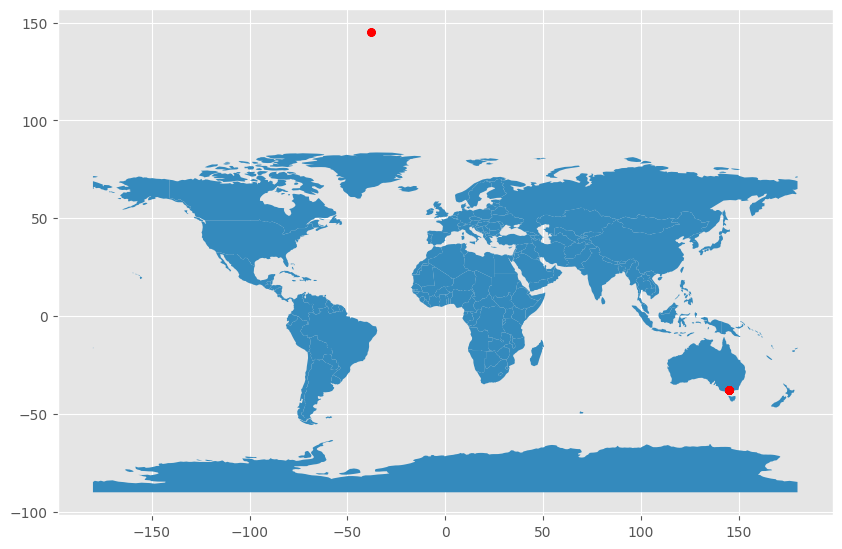

In [45]:
# defines the coordinates of the customers
coordinates = [Point(xy) for xy in zip(dirty_data_raw['customer_long'], dirty_data_raw['customer_lat'])]
# geodataframe object for spatial opreations
gdf = gpd.GeoDataFrame(dirty_data_raw, geometry = coordinates)
# map object containing low resolution map of the world
map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# plots the maps containg the datapoints from df
gdf.plot(ax = map.plot(figsize = (10, 10)), color = 'red', markersize = 30)

It is clearly observed that the there are observations recorded outside Melbourne which seems to be way beyond our target location.

We will check for the values by filtering out the df based on values greater than -37 for latitude and less than 144 for the longitudes.

In [46]:
geospatial_dirty_df = dirty_data_raw[(dirty_data_raw["customer_lat"] > -37) & 
                                     (dirty_data_raw["customer_long"] < 144)]
geospatial_dirty_df

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,dirty_flag
30,ORD165219,ID0741702230,2022-10-27,Nickolson,"[('Lucent 330S', 1), ('Universe Note', 2)]",8130,35.520,144.967633,-37.817489,50,Spring,False,0.20887,five stars this phone was in great condition. ...,True,False
149,ORD337266,ID0634783910,2022-05-18,Thompson,"[('Lucent 330S', 2), ('Thunder line', 1)]",4640,65.175,144.937595,-37.813473,0,Autumn,True,0.83791,falla el teléfono no funciona al 100. solo se ...,False,False
162,ORD090574,ID6221450540,2022-02-21,Bakers,"[('Universe Note', 2), ('Thunder line', 2), ('...",15710,97.123,144.983375,-37.808829,0,Summer,True,1.05084,excellent and responsible seller excellent and...,True,False
441,ORD430432,ID1725216511,2022-05-03,Nickolson,"[('Toshika 750', 2), ('pearTV', 1), ('Alcon 10...",32850,34.293,144.965166,-37.802655,50,Autumn,False,1.81581,"great service experience to summarize it all, ...",True,False
458,ORD016975,ID3208518298,2022-02-13,Nickolson,"[('Toshika 750', 2), ('iAssist Line', 1)]",10865,74.571,144.965089,-37.805442,25,Summer,True,1.51581,nice phone nice phone,True,False


From the above data it can be inferred that the values for latitude and longitude for the records was interchanged. We can fix them by again interchanging the values for both the columns.

In [47]:
# interchanges the values of the records in the above df and 
#sets the dirty flag as true after modifying the data
index_values = list(geospatial_dirty_df.index.values)
for i in index_values:
  dirty_data_raw.at[i, "customer_lat"], dirty_data_raw.at[i, "customer_long"] = dirty_data_raw.at[i, "customer_long"], dirty_data_raw.at[i, "customer_lat"]
  dirty_data_raw.at[i, "dirty_flag"] = True

In [48]:
# verifying the modified records
dirty_data_raw.loc[[30, 149, 162, 441, 458]]

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,dirty_flag
30,ORD165219,ID0741702230,2022-10-27,Nickolson,"[('Lucent 330S', 1), ('Universe Note', 2)]",8130,35.520,-37.817489,144.967633,50,Spring,False,0.20887,five stars this phone was in great condition. ...,True,True
149,ORD337266,ID0634783910,2022-05-18,Thompson,"[('Lucent 330S', 2), ('Thunder line', 1)]",4640,65.175,-37.813473,144.937595,0,Autumn,True,0.83791,falla el teléfono no funciona al 100. solo se ...,False,True
162,ORD090574,ID6221450540,2022-02-21,Bakers,"[('Universe Note', 2), ('Thunder line', 2), ('...",15710,97.123,-37.808829,144.983375,0,Summer,True,1.05084,excellent and responsible seller excellent and...,True,True
441,ORD430432,ID1725216511,2022-05-03,Nickolson,"[('Toshika 750', 2), ('pearTV', 1), ('Alcon 10...",32850,34.293,-37.802655,144.965166,50,Autumn,False,1.81581,"great service experience to summarize it all, ...",True,True
458,ORD016975,ID3208518298,2022-02-13,Nickolson,"[('Toshika 750', 2), ('iAssist Line', 1)]",10865,74.571,-37.805442,144.965089,25,Summer,True,1.51581,nice phone nice phone,True,True


In [49]:
# filter for data that has already been cleaned
filtered_data = dirty_data_raw[dirty_data_raw["dirty_flag"] == True]
filtered_data.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,dirty_flag
3,ORD494678,ID0664380400,2022-06-01,Thompson,"[('Thunder line', 2), ('Universe Note', 1), ('...",10270,42.785,-37.819663,144.972732,25,Winter,True,0.30392,digico sucks!!! the touchscreen got messed up ...,False,True
30,ORD165219,ID0741702230,2022-10-27,Nickolson,"[('Lucent 330S', 1), ('Universe Note', 2)]",8130,35.520,-37.817489,144.967633,50,Spring,False,0.20887,five stars this phone was in great condition. ...,True,True
69,ORD075238,ID3163996209,2022-03-29,Thompson,"[('Thunder line', 2), ('Toshika 750', 1), ('Al...",17630,39.875,-37.802609,144.957187,25,Autumn,False,1.43076,"money back sigo esperando mi reembolso, no se ...",False,True
72,ORD129609,ID1217532949,2022-06-21,Bakers,"[('Universe Note', 1), ('Olivia x460', 1)]",4675,37.314,-37.818048,144.948613,25,Winter,False,0.61352,wrong model # the description says it's model ...,False,True
77,ORD265602,ID6167247184,2022-10-28,Nickolson,"[('Lucent 330S', 2), ('pearTV', 2), ('iStream'...",23870,46.728,-37.819766,144.959023,25,Autumn,False,0.93493,not unlocked phone was supposed to come unlock...,False,True


In [50]:
# list to store the product names
list_items = []
# loops through the column shopping cart
for data in filtered_data["shopping_cart"]:
  # regex to get the name of the item
  matches = re.findall(r'(?:\(\')(.*?)(?:\'\,)',data)
  if matches:
    for items in matches:
      # adds the regex match to the list
      list_items.append(items)
list_items
# set containing name of the unique products
item_set = set(list_items)
print(len(item_set))
  

10


In the above code block we can see we have 10 unique products from the retailers in the data we have already cleaned out. Since there can only be single error in a row we can assume the shopping cart total would be equal to the order_price, therefore we use this data to get the price of the individiual products.

In [51]:
# df to quantities of the products purchased in every order
order_df = pd.DataFrame(columns = sorted(list(item_set)), index = filtered_data.index)
# adds new column to the df
order_df["order_price"] = 0
order_df.head()

,Alcon 10,Candle Inferno,Lucent 330S,Olivia x460,Thunder line,Toshika 750,Universe Note,iAssist Line,iStream,pearTV,order_price
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [52]:
# adds the value of order_price from clean dataframe
for i in list(filtered_data.index.values):
  order_df.at[i, "order_price"] = filtered_data.at[i, "order_price"]
order_df.head()

,Alcon 10,Candle Inferno,Lucent 330S,Olivia x460,Thunder line,Toshika 750,Universe Note,iAssist Line,iStream,pearTV,order_price
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10270
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8130
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17630
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4675
77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23870


In [53]:
for i in list(filtered_data.index.values):
  # regex to find the peoduct name and item quantity
  matches = re.findall(r'(?:\(\')(.*?)(?:\'\, )(\d*)',filtered_data.loc[i, "shopping_cart"])
  for products in matches:
    # adds the quantity from match object at the index of product name
    order_df.at[i, products[0]] = products[1]
# all na values are set as 0
order_df = order_df.fillna(0)
order_df.head()

,Alcon 10,Candle Inferno,Lucent 330S,Olivia x460,Thunder line,Toshika 750,Universe Note,iAssist Line,iStream,pearTV,order_price
3,0,0,2,0,2,0,1,0,0,0,10270
30,0,0,1,0,0,0,2,0,0,0,8130
69,1,0,0,0,2,1,0,0,0,0,17630
72,0,0,0,1,0,0,1,0,0,0,4675
77,0,0,2,0,0,2,0,0,1,2,23870


Since we have 10 products in total we fetch the top 10 rows from the order df in order to 10 linear equations and solve them using numpy module to get the price values for individual products.

In [54]:
# stores the top 10 rows from order df
alg_df = order_df.head(10)

In [55]:
# creates an n dimension array from the values of each column in the df
cart_arr = np.array(alg_df.iloc[:, :-1].values, dtype=np.int64)
# creates n dimension array for the order price
order_arr = np.array(alg_df.iloc[:, -1].values, dtype=np.int64)

In [56]:
order_arr

array([10270,  8130, 17630,  4675, 23870, 18160, 16735,  4640, 15710,
       21350])

In [57]:
cart_arr

array([[0, 0, 2, 0, 2, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 2, 0, 0, 0],
       [1, 0, 0, 0, 2, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 2, 0, 0, 2, 0, 0, 1, 2],
       [0, 2, 1, 0, 0, 0, 1, 0, 0, 2],
       [0, 1, 2, 1, 0, 0, 0, 0, 0, 2],
       [0, 0, 2, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 2, 2, 0, 0],
       [2, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [58]:
# solves linear equation and stors the result 
item_prices = np.linalg.solve(cart_arr, order_arr)
item_prices

array([8950.,  430., 1230., 1225., 2180., 4320., 3450., 2225.,  150.,
       6310.])

In [59]:
# list containing the product names
prod_name = order_df.columns[:-1]
# zips the products as keys and prices as values in a dict
prices_value = dict(zip(prod_name, item_prices))
prices_value


{'Alcon 10': 8950.0,
 'Candle Inferno': 429.9999999999977,
 'Lucent 330S': 1229.9999999999982,
 'Olivia x460': 1224.999999999999,
 'Thunder line': 2180.0000000000005,
 'Toshika 750': 4319.999999999999,
 'Universe Note': 3450.000000000001,
 'iAssist Line': 2224.999999999998,
 'iStream': 149.99999999999923,
 'pearTV': 6310.000000000003}

In [60]:
# df containing the dirty data
dirty_data = dirty_data_raw[dirty_data_raw["dirty_flag"] == False]
dirty_data.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,dirty_flag
0,ORD430562,ID0641028631,2022-07-11,Thompson,"[('Universe Note', 2), ('Lucent 330S', 1), ('A...",26030,56.593,-37.810492,144.943228,25,Winter,True,0.41601,"great deal really responsive, large colorful s...",True,False
1,ORD247368,ID6167413282,2022-12-04,Thompson,"[('Lucent 330S', 2), ('Olivia x460', 2), ('iSt...",5060,94.560,-37.816226,144.956720,0,Summer,True,0.93635,it works just like a olivia universe s4 that w...,True,False
2,ORD444928,ID1281079287,2022-06-11,Thompson,"[('Toshika 750', 2), ('pearTV', 1)]",14950,41.693,-37.799622,144.955018,50,Winter,True,1.61224,love the phone. i had one at full price. but l...,True,False
4,ORD313132,ID0598347145,2022-12-04,Nickolson,"[('Olivia x460', 2), ('iStream', 2), ('Candle ...",3180,36.466,-37.814024,144.963355,50,Summer,False,0.74547,better than expected still learning how to use...,True,False
5,ORD376523,ID0291483919,2022-12-19,Thompson,"[('iAssist Line', 2), ('Universe Note', 2)]",11350,66.643,-37.815341,144.951174,25,Summer,True,0.46745,google pixel best,True,False


In [61]:
# check if the direty data contains 10 items or not
list_items = []
for data in dirty_data["shopping_cart"]:
  matches = re.findall(r'(?:\(\')(.*?)(?:\'\,)',data)
  if matches:
    for items in matches:
      list_items.append(items)
list_items
item_set = set(list_items)
item_set

{'Alcon 10',
 'Candle Inferno',
 'Lucent 330S',
 'Olivia x460',
 'Thunder line',
 'Toshika 750',
 'Universe Note',
 'iAssist Line',
 'iStream',
 'pearTV'}

In [62]:
order_df = pd.DataFrame(columns = sorted(list(item_set)), index = dirty_data.index)
order_df["total_price"] = 0
order_df.head()

,Alcon 10,Candle Inferno,Lucent 330S,Olivia x460,Thunder line,Toshika 750,Universe Note,iAssist Line,iStream,pearTV,total_price
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [63]:
for i in list(dirty_data.index.values):
    matches = re.findall(r'(?:\(\')(.*?)(?:\'\, )(\d*)',dirty_data.loc[i, "shopping_cart"])
    for products in matches:
      order_df.at[i, products[0]] = products[1]
    order_df.at[i, "order_price"] = dirty_data.at[i, "order_price"]
order_df = order_df.fillna(0)

In [64]:
order_df.head()

,Alcon 10,Candle Inferno,Lucent 330S,Olivia x460,Thunder line,Toshika 750,Universe Note,iAssist Line,iStream,pearTV,total_price,order_price
0,2,0,1,0,0,0,2,0,0,0,0,26030.0
1,0,0,2,2,0,0,0,0,1,0,0,5060.0
2,0,0,0,0,0,2,0,0,0,1,0,14950.0
4,0,1,0,2,0,0,0,0,2,0,0,3180.0
5,0,0,0,0,0,0,2,2,0,0,0,11350.0


In [65]:
for i in list(order_df.index.values):
  # for each row in the df sets the price of the product and multiply with the quantity
  alcon_10 = float(order_df.loc[i,'Alcon 10'])* float(prices_value['Alcon 10'])
  candle_iferno = float(order_df.loc[i,'Candle Inferno'])* float(prices_value['Candle Inferno'])
  lucent_330s = float(order_df.loc[i,'Lucent 330S'])* float(prices_value['Lucent 330S'])
  olivia_x460 = float(order_df.loc[i,'Olivia x460'])* float(prices_value['Olivia x460'])
  thunder_line = float(order_df.loc[i,'Thunder line'])* float(prices_value['Thunder line'])
  toshika_750 = float(order_df.loc[i,'Toshika 750'])* float(prices_value['Toshika 750'])
  universe_note = float(order_df.loc[i,'Universe Note'])* float(prices_value['Universe Note'])
  iassist_line = float(order_df.loc[i,'iAssist Line'])* float(prices_value['iAssist Line'])
  istream = float(order_df.loc[i,'iStream'])* float(prices_value['iStream'])
  peartv = float(order_df.loc[i,'pearTV'])* float(prices_value['pearTV'])

  # sum of the shopping cart total
  total_price = (alcon_10 + candle_iferno + lucent_330s + 
                               olivia_x460 + thunder_line + toshika_750 + 
                               universe_note + iassist_line + 
                               iassist_line + istream + peartv)
  order_df.at[i,"total_price"] = total_price
order_df.head()

,Alcon 10,Candle Inferno,Lucent 330S,Olivia x460,Thunder line,Toshika 750,Universe Note,iAssist Line,iStream,pearTV,total_price,order_price
0,2,0,1,0,0,0,2,0,0,0,26030.0,26030.0
1,0,0,2,2,0,0,0,0,1,0,5060.0,5060.0
2,0,0,0,0,0,2,0,0,0,1,14950.0,14950.0
4,0,1,0,2,0,0,0,0,2,0,3180.0,3180.0
5,0,0,0,0,0,0,2,2,0,0,15800.0,11350.0


In [66]:
# returns the df where actual price is not equal to the order_price
cart_dirty_df = order_df[round(order_df['total_price'],3) != round(order_df["order_price"],3)]
cart_dirty_df.head()

,Alcon 10,Candle Inferno,Lucent 330S,Olivia x460,Thunder line,Toshika 750,Universe Note,iAssist Line,iStream,pearTV,total_price,order_price
5,0,0,0,0,0,0,2,2,0,0,15800.0,11350.0
6,0,0,0,0,0,0,2,2,0,0,15800.0,11350.0
10,0,0,0,0,0,0,0,2,2,0,9200.0,4750.0
11,0,0,0,0,1,0,0,1,0,0,6630.0,4405.0
12,2,0,0,0,0,0,2,2,0,2,46320.0,41870.0


In [67]:
# replaces the order_price values with the calculated total price
for i in list(cart_dirty_df.index.values):
  dirty_data_raw.at[i, 'order_price'] = cart_dirty_df.loc[i, 'total_price']
  # sets dirty flag as true for the modified data
  dirty_data_raw.at[i, 'dirty_flag'] = True
clean_data_df = dirty_data_raw.copy()
clean_data_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,dirty_flag
0,ORD430562,ID0641028631,2022-07-11,Thompson,"[('Universe Note', 2), ('Lucent 330S', 1), ('A...",26030.0,56.593,-37.810492,144.943228,25,Winter,True,0.41601,"great deal really responsive, large colorful s...",True,False
1,ORD247368,ID6167413282,2022-12-04,Thompson,"[('Lucent 330S', 2), ('Olivia x460', 2), ('iSt...",5060.0,94.560,-37.816226,144.956720,0,Summer,True,0.93635,it works just like a olivia universe s4 that w...,True,False
2,ORD444928,ID1281079287,2022-06-11,Thompson,"[('Toshika 750', 2), ('pearTV', 1)]",14950.0,41.693,-37.799622,144.955018,50,Winter,True,1.61224,love the phone. i had one at full price. but l...,True,False
3,ORD494678,ID0664380400,2022-06-01,Thompson,"[('Thunder line', 2), ('Universe Note', 1), ('...",10270.0,42.785,-37.819663,144.972732,25,Winter,True,0.30392,digico sucks!!! the touchscreen got messed up ...,False,True
4,ORD313132,ID0598347145,2022-12-04,Nickolson,"[('Olivia x460', 2), ('iStream', 2), ('Candle ...",3180.0,36.466,-37.814024,144.963355,50,Summer,False,0.74547,better than expected still learning how to use...,True,False


In [68]:
# checks and return the df where date is not in standard format
invalid_dates = clean_data_df[pd.to_datetime(clean_data_df['date'], 
                                             format='%Y-%m-%d', 
                                             errors='coerce').isna()]
invalid_dates

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,dirty_flag
109,ORD025505,ID0441996141,2022-15-01,Bakers,"[('Olivia x460', 2), ('Lucent 330S', 2)]",4910.0,31.156,-37.819742,145.001089,50,Summer,False,1.20094,will not work on metropcs metropcs could not a...,False,False
138,ORD090649,ID6167279411,2022-28-07,Nickolson,"[('Thunder line', 2), ('pearTV', 2)]",16980.0,38.056,-37.810244,144.962155,25,Winter,False,1.13452,will never buy online again having problems wi...,False,False
276,ORD417879,ID0703557071,2022-Jul-03,Thompson,"[('Candle Inferno', 2), ('iAssist Line', 1)]",5310.0,59.839,-37.807122,144.957849,25,Winter,True,1.13170,this phone is amazing excellent,True,True
291,ORD126833,ID4735836869,Wed Mar 9 00:00:00 2022,Thompson,"[('Lucent 330S', 1), ('Thunder line', 1), ('Ca...",13170.0,40.979,-37.803264,144.950060,50,Autumn,True,1.07992,five stars great product,True,True
314,ORD287041,ID0255058357,Mon Nov 7 00:00:00 2022,Nickolson,"[('iAssist Line', 2), ('pearTV', 2)]",21520.0,57.699,-37.812925,144.971451,25,Spring,False,0.65294,lucent 6 perfect!!! it is everything the adds ...,True,True
415,ORD388282,ID0775945614,2022-13-09,Nickolson,"[('Thunder line', 2), ('Candle Inferno', 2), (...",23270.0,106.252,-37.807084,144.962701,0,Spring,True,1.41590,had the previous version of this tablet and wa...,True,False
454,ORD365225,ID3130999255,2022-27-12,Bakers,"[('Candle Inferno', 2), ('Thunder line', 1)]",3040.0,80.994,-37.814270,145.011127,0,Summer,False,1.47663,love the storage! love it. nearly indestructib...,True,False


In [69]:
for i in list(invalid_dates.index.values):
  try:
    # changes the date column to datetime format and identifies the actual format itself
    clean_data_df.at[i,'date'] = pd.to_datetime(clean_data_df.loc[i,'date'], 
                               infer_datetime_format=True, errors = 'raise')
    clean_data_df.at[i,'dirty_flag'] = True
  except:
    # for the format that throws error while conversion
    clean_data_df.at[i, 'date'] = pd.to_datetime(clean_data_df.loc[i,'date'], 
                                                 format='%Y-%d-%m')
    clean_data_df.at[i,'dirty_flag'] = True
# strips the time from datetime type object and returns the date part
clean_data_df['date'] = pd.to_datetime(clean_data_df['date']).dt.strftime('%Y-%m-%d')

In [70]:
clean_data_df.loc[109,'date']

'2022-01-15'

In [71]:
clean_data_df.loc[314,'date']

'2022-11-07'

**2.1: Calculate Arc Distance**

---
This section is used to calculate the distance between the customer and their nearest warehouse. The calculated distance is then compared to the one in the df and checked for its accuracy.

In [72]:
# df contaning order_id, nearest_warehouse and customer coordinates for the remaining dirty data
loc_df = clean_data_df.loc[clean_data_df['dirty_flag'] == False, 
                           ['order_id', 'nearest_warehouse', 'customer_lat', 'customer_long','distance_to_nearest_warehouse','dirty_flag']]
loc_df.head()

,order_id,nearest_warehouse,customer_lat,customer_long,distance_to_nearest_warehouse,dirty_flag
0,ORD430562,Thompson,-37.810492,144.943228,0.41601,False
1,ORD247368,Thompson,-37.816226,144.956720,0.93635,False
2,ORD444928,Thompson,-37.799622,144.955018,1.61224,False
4,ORD313132,Nickolson,-37.814024,144.963355,0.74547,False
7,ORD273127,Bakers,-37.820408,145.013186,1.95858,False


In [73]:
# defines the latitudes and longitudes for the warehouses
nicolson_lat = warehouse_df.loc[0,'lat']
nicolson_long = warehouse_df.loc[0,'lon']
thompson_lat = warehouse_df.loc[1,'lat']
thompson_long = warehouse_df.loc[1,'lon']
bakers_lat = warehouse_df.loc[2,'lat']
bakers_long = warehouse_df.loc[2,'lon']
# iterates over the missing data df
for i in list(loc_df.index.values):
  # defines the customer's locations
  long1 = loc_df.loc[i, 'customer_long']
  lat1 = loc_df.loc[i, 'customer_lat']
  # distance from nicolson
  dist_n = round(calculate_min_distance(lat1, nicolson_lat, 
                                        long1, nicolson_long), 5)
  # distance from thompson
  dist_t = round(calculate_min_distance(lat1, thompson_lat, 
                                        long1, thompson_long), 5)
  # distance from bakers
  dist_b = round(calculate_min_distance(lat1, bakers_lat, 
                                        long1, bakers_long), 5)
  
  # checks for the least distance between the customers and the warehouses
  dist = min(dist_n, dist_t, dist_b)
  if dist == dist_n:
    if not loc_df.loc[i, 'distance_to_nearest_warehouse'] == dist:
      loc_df.at[i, 'distance_to_nearest_warehouse'] = dist
      loc_df.at[i, 'dirty_flag'] = True
    if not loc_df.loc[i, 'nearest_warehouse'] == 'Nickolson':
      loc_df.at[i, 'nearest_warehouse'] = 'Nickolson'
      loc_df.at[i, 'dirty_flag'] = True
  elif dist == dist_t:
    if not loc_df.loc[i, 'distance_to_nearest_warehouse'] == dist:
      loc_df.at[i, 'distance_to_nearest_warehouse'] = dist
      loc_df.at[i, 'dirty_flag'] = True
    if not loc_df.loc[i, 'nearest_warehouse'] == 'Thompson':
      loc_df.at[i, 'nearest_warehouse'] = 'Thompson'
      loc_df.at[i, 'dirty_flag'] = True
  else:
    if not loc_df.loc[i, 'distance_to_nearest_warehouse'] == dist:
      loc_df.at[i, 'distance_to_nearest_warehouse'] = dist
      loc_df.at[i, 'dirty_flag'] = True
    if not loc_df.loc[i, 'nearest_warehouse'] == 'Bakers':
      loc_df.at[i, 'nearest_warehouse'] = 'Bakers'
      loc_df.at[i, 'dirty_flag'] = True
loc_df.head()

,order_id,nearest_warehouse,customer_lat,customer_long,distance_to_nearest_warehouse,dirty_flag
0,ORD430562,Thompson,-37.810492,144.943228,0.41601,False
1,ORD247368,Thompson,-37.816226,144.956720,0.93635,False
2,ORD444928,Thompson,-37.799622,144.955018,1.61224,False
4,ORD313132,Nickolson,-37.814024,144.963355,0.74547,False
7,ORD273127,Bakers,-37.820408,145.013186,1.95858,False


In [74]:
loc_df.describe()

,customer_lat,customer_long,distance_to_nearest_warehouse
count,317.000000,317.000000,317.000000
mean,-37.812023,144.965309,1.041224
std,0.007073,0.019625,0.454766
min,-37.825437,144.927246,0.065600
25%,-37.818012,144.952046,0.728770
50%,-37.811987,144.963837,1.025200
75%,-37.806566,144.977673,1.316160
max,-37.798632,145.014737,2.237530


In [75]:
for i in list(loc_df.index.values):
  # checks if the calculated distance is equal to the given distance
  if loc_df.loc[i, 'dirty_flag'] == True:
    # if not changes the values to calculated distance
    clean_data_df.at[i, 'distance_to_nearest_warehouse'] = loc_df.loc[i,'distance_to_nearest_warehouse']
    clean_data_df.at[i, 'nearest_warehouse'] = loc_df.loc[i,'nearest_warehouse']
    clean_data_df.at[i, 'dirty_flag'] = True
clean_data_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,dirty_flag
0,ORD430562,ID0641028631,2022-07-11,Thompson,"[('Universe Note', 2), ('Lucent 330S', 1), ('A...",26030.0,56.593,-37.810492,144.943228,25,Winter,True,0.41601,"great deal really responsive, large colorful s...",True,False
1,ORD247368,ID6167413282,2022-12-04,Thompson,"[('Lucent 330S', 2), ('Olivia x460', 2), ('iSt...",5060.0,94.560,-37.816226,144.956720,0,Summer,True,0.93635,it works just like a olivia universe s4 that w...,True,False
2,ORD444928,ID1281079287,2022-06-11,Thompson,"[('Toshika 750', 2), ('pearTV', 1)]",14950.0,41.693,-37.799622,144.955018,50,Winter,True,1.61224,love the phone. i had one at full price. but l...,True,False
3,ORD494678,ID0664380400,2022-06-01,Thompson,"[('Thunder line', 2), ('Universe Note', 1), ('...",10270.0,42.785,-37.819663,144.972732,25,Winter,True,0.30392,digico sucks!!! the touchscreen got messed up ...,False,True
4,ORD313132,ID0598347145,2022-12-04,Nickolson,"[('Olivia x460', 2), ('iStream', 2), ('Candle ...",3180.0,36.466,-37.814024,144.963355,50,Summer,False,0.74547,better than expected still learning how to use...,True,False


**2.2: Sentiment Analysis**


---
In this section we perform sentiment analysis on the feeback provided by the customer for their last purchase. We achieve this by using vader_lexicon module from nltk library which performs sentiment analysis and provides the polarity score for it. A customer is happy with their purchase when the compund score is greater than 0.05.


In [76]:
# creates a df with remaining dirty data
feedback_df = clean_data_df.loc[clean_data_df['dirty_flag']== False,['order_id','latest_customer_review']]
# adds column for polarity_score to df
feedback_df['polarity_score'] = 0
# adds new column which is the happiness flag
feedback_df['is_happy'] = False
feedback_df.head()

,order_id,latest_customer_review,polarity_score,is_happy
0,ORD430562,"great deal really responsive, large colorful s...",0,False
1,ORD247368,it works just like a olivia universe s4 that w...,0,False
2,ORD444928,love the phone. i had one at full price. but l...,0,False
4,ORD313132,better than expected still learning how to use...,0,False
7,ORD273127,more feathers then the s7 model of olivia my w...,0,False


In [77]:
# initializes sentiment analyzer
sent_analyzer = SentimentIntensityAnalyzer()
# variable to hold boolean for hapoiness index
pos_fdbk = False
# loops through the df
for i in list(feedback_df.index.values):
  # feeback provided by the customer
  feedback = feedback_df.loc[i,'latest_customer_review']
  # return the polarity score dict for the review
  score = sent_analyzer.polarity_scores(feedback)
  # checks the compound score with the threshold value
  if score['compound'] >= 0.05:
    # sets happiness flag as true
    pos_fdbk = True
  else:
    pos_fdbk = False
  # adds the compound score to the df
  feedback_df.at[i,'polarity_score'] = score['compound']
  # adds happiness flag to the df
  feedback_df.at[i,'is_happy'] = pos_fdbk
feedback_df.head()

,order_id,latest_customer_review,polarity_score,is_happy
0,ORD430562,"great deal really responsive, large colorful s...",0.9213,True
1,ORD247368,it works just like a olivia universe s4 that w...,0.3400,True
2,ORD444928,love the phone. i had one at full price. but l...,0.9423,True
4,ORD313132,better than expected still learning how to use...,0.7264,True
7,ORD273127,more feathers then the s7 model of olivia my w...,0.3612,True


In [78]:
# loops through feedback df
for i in list(feedback_df.index.values):
  # checks if actual data is same as the calculated
  if feedback_df.loc[i, 'is_happy'] != clean_data_df.loc[i,'is_happy_customer']:
    # if not changes the value to calculated field
    clean_data_df.at[i,'is_happy_customer'] = feedback_df.loc[i, 'is_happy']
    # sets dirty flag as true for the modified data
    clean_data_df.at[i,'dirty_flag'] = True

**2.3: Expedited delivery**


---

In this section we will check if the is_expedited_delivery correct in the data. We know that there is linear depedency between expedited delivery and delivery charges, also delivery charges are always right, also season, distance_from_nearest_warehouse and is_happy has already been fixed therefore we can assume there might be some noise in the delivery charges when predicted using the model described in Missing Data Section. This noise will cause outliers which are identified using residual technique. After identifying the outliers we will modify the value of the is_expedited_delivery to opposite of what it actually is.



In [79]:
# defines the testing data
lm_df = clean_data_df.loc[clean_data_df['dirty_flag']== False].copy()
# calculate the delivery charges without the discount in testing data
for i in list(lm_df.index.values):
  discounted_price = (lm_df.loc[i,"delivery_charges"])/(1 - (lm_df.loc[i,"delivery_discount"]/100))
  lm_df.at[i,"discounted_delivery"] = discounted_price
lm_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,dirty_flag,discounted_delivery
0,ORD430562,ID0641028631,2022-07-11,Thompson,"[('Universe Note', 2), ('Lucent 330S', 1), ('A...",26030.0,56.593,-37.810492,144.943228,25,Winter,True,0.41601,"great deal really responsive, large colorful s...",True,False,75.457333
1,ORD247368,ID6167413282,2022-12-04,Thompson,"[('Lucent 330S', 2), ('Olivia x460', 2), ('iSt...",5060.0,94.560,-37.816226,144.956720,0,Summer,True,0.93635,it works just like a olivia universe s4 that w...,True,False,94.560000
2,ORD444928,ID1281079287,2022-06-11,Thompson,"[('Toshika 750', 2), ('pearTV', 1)]",14950.0,41.693,-37.799622,144.955018,50,Winter,True,1.61224,love the phone. i had one at full price. but l...,True,False,83.386000
4,ORD313132,ID0598347145,2022-12-04,Nickolson,"[('Olivia x460', 2), ('iStream', 2), ('Candle ...",3180.0,36.466,-37.814024,144.963355,50,Summer,False,0.74547,better than expected still learning how to use...,True,False,72.932000
7,ORD273127,ID4301655729,2022-10-12,Bakers,"[('Alcon 10', 2), ('Lucent 330S', 2), ('Thunde...",24720.0,83.616,-37.820408,145.013186,0,Spring,False,1.95858,more feathers then the s7 model of olivia my w...,True,False,83.616000


In [80]:
# encodes the seasons to a numeric value
season_encoded = pd.get_dummies(lm_df['season'], prefix='season')
# adds the encoded season to the actual df
lm_df_encoded = pd.concat([lm_df, season_encoded], axis=1)
# converts boolean to int binary type
lm_df_encoded['is_expedited_delivery'] = lm_df_encoded['is_expedited_delivery'].astype(int)
lm_df_encoded['is_happy_customer'] = lm_df_encoded['is_happy_customer'].astype(int)
lm_df_encoded.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,...,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,dirty_flag,discounted_delivery,season_Autumn,season_Spring,season_Summer,season_Winter
0,ORD430562,ID0641028631,2022-07-11,Thompson,"[('Universe Note', 2), ('Lucent 330S', 1), ('A...",26030.0,56.593,-37.810492,144.943228,25,...,1,0.41601,"great deal really responsive, large colorful s...",1,False,75.457333,0,0,0,1
1,ORD247368,ID6167413282,2022-12-04,Thompson,"[('Lucent 330S', 2), ('Olivia x460', 2), ('iSt...",5060.0,94.560,-37.816226,144.956720,0,...,1,0.93635,it works just like a olivia universe s4 that w...,1,False,94.560000,0,0,1,0
2,ORD444928,ID1281079287,2022-06-11,Thompson,"[('Toshika 750', 2), ('pearTV', 1)]",14950.0,41.693,-37.799622,144.955018,50,...,1,1.61224,love the phone. i had one at full price. but l...,1,False,83.386000,0,0,0,1
4,ORD313132,ID0598347145,2022-12-04,Nickolson,"[('Olivia x460', 2), ('iStream', 2), ('Candle ...",3180.0,36.466,-37.814024,144.963355,50,...,0,0.74547,better than expected still learning how to use...,1,False,72.932000,0,0,1,0
7,ORD273127,ID4301655729,2022-10-12,Bakers,"[('Alcon 10', 2), ('Lucent 330S', 2), ('Thunde...",24720.0,83.616,-37.820408,145.013186,0,...,0,1.95858,more feathers then the s7 model of olivia my w...,1,False,83.616000,0,1,0,0


In [81]:
# predicts the values for delivery charges based on the independent variables
lm_df_encoded["predicted_delivery"]= model.predict(lm_df_encoded[['season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter',
          'is_expedited_delivery', 'distance_to_nearest_warehouse', 'is_happy_customer']])

In [82]:
# calculates resilduals which is the difference between the actual and predicted values
# adds the residuals to the df
lm_df_encoded["residuals"] = (lm_df_encoded['discounted_delivery'] - lm_df_encoded['predicted_delivery'])

In [83]:
# statistical inference of the residual column
stat_info = lm_df_encoded[["residuals"]].describe()
stat_info

,residuals
count,306.000000
mean,-0.383846
std,3.782315
min,-19.078000
25%,-2.823000
50%,-0.103750
75%,2.065000
max,19.953500


In [84]:
# lower threshold for outlier
lower_limit = float(stat_info.loc["25%"] - 1.5*(stat_info.loc["75%"] - stat_info.loc["25%"]))
# upper threshold for outlier

upper_limit = float(stat_info.loc["75%"] + 1.5*(stat_info.loc["75%"] - stat_info.loc["25%"]))
print(f'upper limit: {upper_limit} :: lower limit: {lower_limit}')

upper limit: 9.397000000000004 :: lower limit: -10.155000000000003


In [85]:
# returns the list of indices which are outliers in the data
outliers = list(lm_df_encoded[(lm_df_encoded['residuals'] < lower_limit) | (lm_df_encoded['residuals'] > upper_limit)].index)
len(outliers)

7

In [86]:
# iterates through the list
for i in outliers:
  # if is_expedited delivery is true
  if clean_data_df.loc[i, "is_expedited_delivery"]:
    # change it to false
    clean_data_df.at[i, "is_expedited_delivery"] = False
    # set dirty flag as True
    clean_data_df.at[i, "dirty_flag"] = True
  else:
    # change it to True
    clean_data_df.at[i, "is_expedited_delivery"] = True
    # set dirty flag to true
    clean_data_df.at[i, "dirty_flag"] = True
clean_data_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,dirty_flag
0,ORD430562,ID0641028631,2022-07-11,Thompson,"[('Universe Note', 2), ('Lucent 330S', 1), ('A...",26030.0,56.593,-37.810492,144.943228,25,Winter,True,0.41601,"great deal really responsive, large colorful s...",True,False
1,ORD247368,ID6167413282,2022-12-04,Thompson,"[('Lucent 330S', 2), ('Olivia x460', 2), ('iSt...",5060.0,94.560,-37.816226,144.956720,0,Summer,True,0.93635,it works just like a olivia universe s4 that w...,True,False
2,ORD444928,ID1281079287,2022-06-11,Thompson,"[('Toshika 750', 2), ('pearTV', 1)]",14950.0,41.693,-37.799622,144.955018,50,Winter,True,1.61224,love the phone. i had one at full price. but l...,True,False
3,ORD494678,ID0664380400,2022-06-01,Thompson,"[('Thunder line', 2), ('Universe Note', 1), ('...",10270.0,42.785,-37.819663,144.972732,25,Winter,True,0.30392,digico sucks!!! the touchscreen got messed up ...,False,True
4,ORD313132,ID0598347145,2022-12-04,Nickolson,"[('Olivia x460', 2), ('iStream', 2), ('Candle ...",3180.0,36.466,-37.814024,144.963355,50,Summer,False,0.74547,better than expected still learning how to use...,True,False


In [87]:
# creates a copy of clean data
final_clean_df = clean_data_df.iloc[:, :-1].copy()
final_clean_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD430562,ID0641028631,2022-07-11,Thompson,"[('Universe Note', 2), ('Lucent 330S', 1), ('A...",26030.0,56.593,-37.810492,144.943228,25,Winter,True,0.41601,"great deal really responsive, large colorful s...",True
1,ORD247368,ID6167413282,2022-12-04,Thompson,"[('Lucent 330S', 2), ('Olivia x460', 2), ('iSt...",5060.0,94.560,-37.816226,144.956720,0,Summer,True,0.93635,it works just like a olivia universe s4 that w...,True
2,ORD444928,ID1281079287,2022-06-11,Thompson,"[('Toshika 750', 2), ('pearTV', 1)]",14950.0,41.693,-37.799622,144.955018,50,Winter,True,1.61224,love the phone. i had one at full price. but l...,True
3,ORD494678,ID0664380400,2022-06-01,Thompson,"[('Thunder line', 2), ('Universe Note', 1), ('...",10270.0,42.785,-37.819663,144.972732,25,Winter,True,0.30392,digico sucks!!! the touchscreen got messed up ...,False
4,ORD313132,ID0598347145,2022-12-04,Nickolson,"[('Olivia x460', 2), ('iStream', 2), ('Candle ...",3180.0,36.466,-37.814024,144.963355,50,Summer,False,0.74547,better than expected still learning how to use...,True


In [88]:
# creates a csv file from the clean data df
final_clean_df.to_csv('/content/drive/MyDrive/Assessment2/31940757_dirty_data_solution.csv',
index = False)

## **3: Outlier Data**


---
This section of the assessment deals with outlier handling and removal. Since the delivery charges are linearly depedent in season, distance from the warehouse, satisfaction from the last purchase and expedited delivery, we use a linear regression model to predict the delivery price. Then we use residual method approach to figure out the difference between the actual and predicted values and check if the values fit within the Inter Quartile Range. The datapoints outside IQR both at upper and lower ends are treated as outliers.


In [89]:
# loads data from csv into dataframe
data_df = pd.read_csv("/content/drive/Shareddrives/FIT5196_S1_2023/Assessment2/student_data/31940757_outlier_data.csv")
# prints top rows from the dataframe
data_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD120069,ID0444352324,2022-11-25,Nickolson,"[('Universe Note', 2), ('Candle Inferno', 1), ...",9705,40.2200,-37.829848,144.966863,50,Spring,False,1.27472,it is what i expected it is what expected! i a...,True
1,ORD169610,ID1463620869,2022-06-12,Bakers,"[('iAssist Line', 1), ('Universe Note', 1)]",5675,12.8955,-37.818662,145.000787,50,Winter,False,1.08128,one star after 1 month dont charge ane more,False
2,ORD033455,ID3148693051,2022-10-05,Nickolson,"[('Thunder line', 1), ('Candle Inferno', 2), (...",12400,129.1680,-37.812028,144.972213,0,Spring,True,0.76755,not new received open box. the phone was not s...,False
3,ORD176607,ID4740822036,2022-02-11,Thompson,"[('Candle Inferno', 1), ('Alcon 10', 1)]",9380,144.9675,-37.803392,144.949986,0,Summer,True,1.06452,the goat of phones. best phone in the game her...,True
4,ORD229734,ID0332152661,2022-02-22,Nickolson,"[('Candle Inferno', 2), ('Universe Note', 2)]",7760,24.8335,-37.806813,144.977625,50,Summer,True,1.49144,perfect love it.,True


<Axes: >

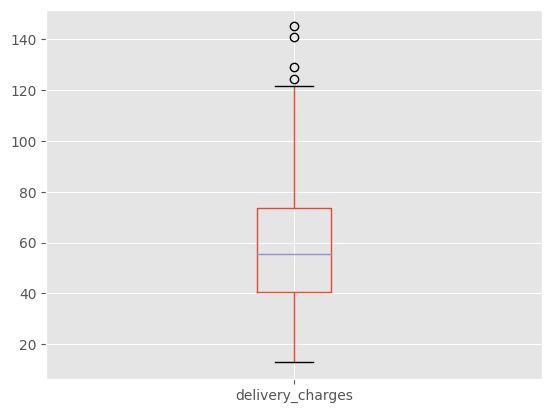

In [90]:
# boxplot depicting the distribution of the delivery charges
data_df.boxplot(column = 'delivery_charges')

In [91]:
# calculation for delovery charges without the discount
data_df["discounted_delivery"] = 0
discounted_price = 0
# loop to iterate through the outlier data
for i in list(data_df.index.values):
  discounted_price = (data_df.loc[i,"delivery_charges"])/(1 - (data_df.loc[i,"delivery_discount"]/100))
  # adds the calulcated delivery price to the df
  data_df.at[i,"discounted_delivery"] = discounted_price
data_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,discounted_delivery
0,ORD120069,ID0444352324,2022-11-25,Nickolson,"[('Universe Note', 2), ('Candle Inferno', 1), ...",9705,40.2200,-37.829848,144.966863,50,Spring,False,1.27472,it is what i expected it is what expected! i a...,True,80.4400
1,ORD169610,ID1463620869,2022-06-12,Bakers,"[('iAssist Line', 1), ('Universe Note', 1)]",5675,12.8955,-37.818662,145.000787,50,Winter,False,1.08128,one star after 1 month dont charge ane more,False,25.7910
2,ORD033455,ID3148693051,2022-10-05,Nickolson,"[('Thunder line', 1), ('Candle Inferno', 2), (...",12400,129.1680,-37.812028,144.972213,0,Spring,True,0.76755,not new received open box. the phone was not s...,False,129.1680
3,ORD176607,ID4740822036,2022-02-11,Thompson,"[('Candle Inferno', 1), ('Alcon 10', 1)]",9380,144.9675,-37.803392,144.949986,0,Summer,True,1.06452,the goat of phones. best phone in the game her...,True,144.9675
4,ORD229734,ID0332152661,2022-02-22,Nickolson,"[('Candle Inferno', 2), ('Universe Note', 2)]",7760,24.8335,-37.806813,144.977625,50,Summer,True,1.49144,perfect love it.,True,49.6670


In [92]:
# creates a copy of the df
outlier_df = data_df.copy()

In [93]:
# encodes the seasons to binary values
season_encoded = pd.get_dummies(data_df['season'], prefix='season')
# adds the encoded seasons to the outlier df
data_encoded_df = pd.concat([data_df, season_encoded], axis=1)
# cast the boolean columns to numerical binary data
data_encoded_df['is_expedited_delivery'] = data_encoded_df['is_expedited_delivery'].astype(int)
data_encoded_df['is_happy_customer'] = data_encoded_df['is_happy_customer'].astype(int)
# dataset containing independent variables
X = data_encoded_df[['season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter',
          'is_expedited_delivery', 'distance_to_nearest_warehouse', 'is_happy_customer']]
# dataset containing the dependent variable
y = data_encoded_df['discounted_delivery']

data_encoded_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,discounted_delivery,season_Autumn,season_Spring,season_Summer,season_Winter
0,ORD120069,ID0444352324,2022-11-25,Nickolson,"[('Universe Note', 2), ('Candle Inferno', 1), ...",9705,40.2200,-37.829848,144.966863,50,Spring,0,1.27472,it is what i expected it is what expected! i a...,1,80.4400,0,1,0,0
1,ORD169610,ID1463620869,2022-06-12,Bakers,"[('iAssist Line', 1), ('Universe Note', 1)]",5675,12.8955,-37.818662,145.000787,50,Winter,0,1.08128,one star after 1 month dont charge ane more,0,25.7910,0,0,0,1
2,ORD033455,ID3148693051,2022-10-05,Nickolson,"[('Thunder line', 1), ('Candle Inferno', 2), (...",12400,129.1680,-37.812028,144.972213,0,Spring,1,0.76755,not new received open box. the phone was not s...,0,129.1680,0,1,0,0
3,ORD176607,ID4740822036,2022-02-11,Thompson,"[('Candle Inferno', 1), ('Alcon 10', 1)]",9380,144.9675,-37.803392,144.949986,0,Summer,1,1.06452,the goat of phones. best phone in the game her...,1,144.9675,0,0,1,0
4,ORD229734,ID0332152661,2022-02-22,Nickolson,"[('Candle Inferno', 2), ('Universe Note', 2)]",7760,24.8335,-37.806813,144.977625,50,Summer,1,1.49144,perfect love it.,1,49.6670,0,0,1,0


In [94]:
# predicts the values for delivery charges based on the independent variables
outlier_df["predicted_delivery"]= model.predict(data_encoded_df[['season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter',
          'is_expedited_delivery', 'distance_to_nearest_warehouse', 'is_happy_customer']])

In [95]:
# calculates resilduals which is the difference between the actual and predicted values
# adds the residuals to the df
outlier_df["residuals"] = (outlier_df['discounted_delivery'] - outlier_df['predicted_delivery'])

In [96]:
outlier_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,discounted_delivery,predicted_delivery,residuals
0,ORD120069,ID0444352324,2022-11-25,Nickolson,"[('Universe Note', 2), ('Candle Inferno', 1), ...",9705,40.2200,-37.829848,144.966863,50,Spring,False,1.27472,it is what i expected it is what expected! i a...,True,80.4400,84.0000,-3.5600
1,ORD169610,ID1463620869,2022-06-12,Bakers,"[('iAssist Line', 1), ('Universe Note', 1)]",5675,12.8955,-37.818662,145.000787,50,Winter,False,1.08128,one star after 1 month dont charge ane more,False,25.7910,48.4375,-22.6465
2,ORD033455,ID3148693051,2022-10-05,Nickolson,"[('Thunder line', 1), ('Candle Inferno', 2), (...",12400,129.1680,-37.812028,144.972213,0,Spring,True,0.76755,not new received open box. the phone was not s...,False,129.1680,83.1250,46.0430
3,ORD176607,ID4740822036,2022-02-11,Thompson,"[('Candle Inferno', 1), ('Alcon 10', 1)]",9380,144.9675,-37.803392,144.949986,0,Summer,True,1.06452,the goat of phones. best phone in the game her...,True,144.9675,94.8750,50.0925
4,ORD229734,ID0332152661,2022-02-22,Nickolson,"[('Candle Inferno', 2), ('Universe Note', 2)]",7760,24.8335,-37.806813,144.977625,50,Summer,True,1.49144,perfect love it.,True,49.6670,97.8750,-48.2080


<Axes: >

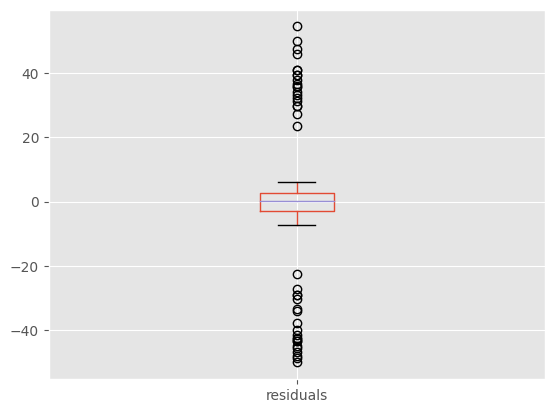

In [97]:
# boxplot showing distribution of the residuals
outlier_df.boxplot(column='residuals')

We can see their are quite a number of datapoints which are beyond IQR. The thresdhold value for data is 1.5* IQR beyond which the data is considered as outliers. Therefore we check for statiscal infromation for this data and check for outliers. IQR is given as difference between the first quartile(25%) and third quartile (75%).


In [98]:
stat_info = outlier_df[["residuals"]].describe()
stat_info

,residuals
count,500.000000
mean,-0.231387
std,11.401629
min,-50.075667
25%,-3.027125
50%,0.081000
75%,2.561625
max,54.505000


In [99]:
lower_limit = float(stat_info.loc["25%"] - 1.5*(stat_info.loc["75%"] - stat_info.loc["25%"]))
upper_limit = float(stat_info.loc["75%"] + 1.5*(stat_info.loc["75%"] - stat_info.loc["25%"]))
print(f'upper limit: {upper_limit} :: lower limit: {lower_limit}')

upper limit: 10.94475 :: lower limit: -11.410249999999998


In [100]:
outliers = list(outlier_df[(outlier_df['residuals'] < lower_limit) | (outlier_df['residuals'] > upper_limit)].index)
len(outliers)

40

We have got 40 outliers in the data which we need to remove.

In [101]:
final_outlier_data = data_df.drop(outliers, axis=0)
final_outlier_data = final_outlier_data.reset_index(drop=True)

In [102]:
final_outlier_data.shape

(460, 16)

In [103]:
final_outlier_data.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,discounted_delivery
0,ORD120069,ID0444352324,2022-11-25,Nickolson,"[('Universe Note', 2), ('Candle Inferno', 1), ...",9705,40.220,-37.829848,144.966863,50,Spring,False,1.27472,it is what i expected it is what expected! i a...,True,80.440000
1,ORD090950,ID0312718322,2022-12-19,Thompson,"[('iAssist Line', 1), ('pearTV', 1), ('iStream...",9265,62.071,-37.802946,144.961628,25,Summer,False,1.67690,came in an original box almost new in perfect ...,True,82.761333
2,ORD311738,ID0575388293,2022-01-05,Nickolson,"[('Alcon 10', 1), ('iStream', 1), ('Toshika 75...",13420,58.390,-37.819969,144.985119,25,Summer,False,1.37749,well worth it!!! everything about this phone i...,True,77.853333
3,ORD413910,ID1492169343,2022-05-11,Thompson,"[('pearTV', 1), ('Alcon 10', 1)]",15260,62.745,-37.801807,144.963613,25,Autumn,True,1.89215,awesome buy! fantastic phone. i did not expect...,True,83.660000
4,ORD496859,ID0591342509,2022-05-14,Nickolson,"[('Lucent 330S', 2), ('Candle Inferno', 2), ('...",6770,38.428,-37.821261,144.957795,25,Autumn,False,1.07550,wish i had read more reviews. phone has scratc...,False,51.237333


In [104]:
# creates a csv file from the clean data df
final_outlier_data.to_csv('/content/drive/MyDrive/Assessment2/31940757_outlier_data_solution.csv',
index = False)